In [16]:
import pandas as pd

# Load training and test datasets
df_train = pd.read_parquet("btc_finbert_sentiment_merged.parquet").reset_index()
df_test = pd.read_csv("test_finbert.csv", parse_dates=["minute"])

# Strip any spaces/newlines and convert to lowercase for consistency
df_train.columns = df_train.columns.str.strip().str.lower()
df_test.columns = df_test.columns.str.strip().str.lower()

# Print column names to verify
print("Columns in train:", df_train.columns.tolist())
print("olumns in test:", df_test.columns.tolist())


✅ Columns in train: ['minute', 'open', 'high', 'low', 'close', 'volume', 'vol_mean_1h', 'rolling_max_24h', 'tier1', 'tier2', 'tier3', 'drawdown_24h', 'log_ret', 'volatility_5m', 'volatility_15m', 'volatility_60m', 'mom_3m', 'mom_10m', 'mom_30m', 'vol_z_10m', 'vol_z_60m', 'label_t1_l5_h15', 'label_t2_l10_h30', 'label_t3_l60_h240', 'label_multiclass', 'allcryptobets', 'allthingscrypto', 'bsccryptolistings', 'bestbitcoinnews', 'bitcoin', 'bitcoinaus', 'bitcoinall', 'bitcoinbeginners', 'bitcoinca', 'bitcoinindia', 'bitcoinmarkets', 'bitcoinmining', 'bitcoinprivate', 'bitcoinuk', 'bitcoinwallpaper', 'bitcoincash', 'cryptoairdrop', 'cryptoart', 'cryptobanter', 'cryptoblades', 'cryptocoldstore', 'cryptocurrencies', 'cryptocurrency', 'cryptocurrencyclassic', 'cryptocurrencymax', 'cryptocurrencymeta', 'cryptocurrencymoons', 'cryptocurrencypump', 'cryptocurrencytrading', 'cryptogemdiscovery', 'cryptohorde', 'cryptoico', 'cryptoindia', 'cryptokami', 'cryptokitties', 'cryptomarkets', 'cryptomars',

In [18]:
print("📌 Train columns:\n", df_train.columns.tolist())


📌 Train columns:
 ['minute', 'open', 'high', 'low', 'close', 'volume', 'vol_mean_1h', 'rolling_max_24h', 'tier1', 'tier2', 'tier3', 'drawdown_24h', 'log_ret', 'volatility_5m', 'volatility_15m', 'volatility_60m', 'mom_3m', 'mom_10m', 'mom_30m', 'vol_z_10m', 'vol_z_60m', 'label_t1_l5_h15', 'label_t2_l10_h30', 'label_t3_l60_h240', 'label_multiclass', 'allcryptobets', 'allthingscrypto', 'bsccryptolistings', 'bestbitcoinnews', 'bitcoin', 'bitcoinaus', 'bitcoinall', 'bitcoinbeginners', 'bitcoinca', 'bitcoinindia', 'bitcoinmarkets', 'bitcoinmining', 'bitcoinprivate', 'bitcoinuk', 'bitcoinwallpaper', 'bitcoincash', 'cryptoairdrop', 'cryptoart', 'cryptobanter', 'cryptoblades', 'cryptocoldstore', 'cryptocurrencies', 'cryptocurrency', 'cryptocurrencyclassic', 'cryptocurrencymax', 'cryptocurrencymeta', 'cryptocurrencymoons', 'cryptocurrencypump', 'cryptocurrencytrading', 'cryptogemdiscovery', 'cryptohorde', 'cryptoico', 'cryptoindia', 'cryptokami', 'cryptokitties', 'cryptomarkets', 'cryptomars', '

In [19]:
# Step 2: Select common features + labels (using label_t1_l5_h15 from train)
common_cols = df_train.columns.intersection(df_test.columns).tolist()
X_train = df_train[common_cols]
X_test = df_test[common_cols]

# Use alternate label from df_train
y_train = df_train['label_t1_l5_h15'].astype('float32')
y_test = df_test['flash_crash'].astype('float32')  # Assuming df_test still has it

# Confirm shapes
print(" Shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


✅ Shapes:
X_train: (4334818, 25)
X_test : (56852, 25)
y_train: (4334818,)
y_test : (56852,)


In [21]:
from sklearn.preprocessing import StandardScaler

X_train_for_model = X_train.drop(columns=['minute'])
X_test_for_model = X_test.drop(columns=['minute'])


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_for_model)
X_test_scaled = scaler.transform(X_test_for_model)


def create_sequence_data(X, y, seq_len=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

seq_len = 60
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train.values, seq_len)
X_test_seq, y_test_seq = create_sequence_data(X_test_scaled, y_test.values, seq_len)



print("X_train_seq:", X_train_seq.shape)
print("y_train_seq:", y_train_seq.shape)
print("X_test_seq :", X_test_seq.shape)
print("y_test_seq :", y_test_seq.shape)


✅ Sequence shapes:
X_train_seq: (4334758, 60, 24)
y_train_seq: (4334758,)
X_test_seq : (56792, 60, 24)
y_test_seq : (56792,)


In [22]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# ✅ Step 4.1: Convert to tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

# ✅ Step 4.2: Create DataLoader for training
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=256,
    shuffle=True
)


print(f" Training tensor shape: {X_train_tensor.shape}")
print(f" DataLoader batches: {len(train_loader)}")


🧠 Training tensor shape: torch.Size([4334758, 60, 24])
📦 DataLoader batches: 16933


In [23]:
import torch.nn as nn

# ✅ Step 5: Define BiLSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=160, num_layers=3, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout, bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # Take the last timestep
        out = self.fc(out)
        return out.view(-1)


In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=160, num_layers=3, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out).view(-1)


input_dim = X_train_seq.shape[2]
model = BiLSTMModel(input_dim=input_dim).to(device)


neg = (y_train_seq == 0).sum()
pos = (y_train_seq == 1).sum()
pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)


criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)


train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32),
                  torch.tensor(y_train_seq, dtype=torch.float32)),
    batch_size=256,
    shuffle=True
)




✅ Step 6 complete: Model ready for training.


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMModel(input_dim=input_dim).to(device)


In [39]:
logits = model(X_batch.to(device))  
loss = criterion(logits, y_batch.to(device)) 


In [ ]:
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

# Preload test tensors to GPU once
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(device)

# DataLoader for test
test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor),
    batch_size=1024,  # Increased batch size
    pin_memory=True
)

# Step 7: Optimized Training Loop
epochs = 2
best_val_loss = float('inf')

for epoch in range(epochs):
    total_loss = 0
    model.train()

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 🔍 Fast Evaluation
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in test_loader:
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs.append(probs)
            all_targets.append(yb)

    preds = torch.cat(all_probs).cpu().numpy()
    targets = torch.cat(all_targets).cpu().numpy()

    preds_binary = (preds > 0.3).astype(int)
    val_loss = F.binary_cross_entropy(torch.tensor(preds), torch.tensor(targets)).item()
    val_acc = accuracy_score(targets, preds_binary)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if epoch > 2 and val_loss > best_val_loss:
        print("⛔ Early stopping triggered.")
        break

    best_val_loss = val_loss


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Final Evaluation
model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for i in range(0, len(X_test_seq), 512):
        xb = torch.tensor(X_test_seq[i:i+512], dtype=torch.float32).to(device)
        yb = torch.tensor(y_test_seq[i:i+512], dtype=torch.float32).to(device)

        logits = model(xb)
        probs = torch.sigmoid(logits)
        test_preds += probs.cpu().numpy().tolist()
        test_targets += yb.cpu().numpy().tolist()

# 🔍 Convert to binary predictions
test_preds_binary = [1 if p > 0.3 else 0 for p in test_preds]

# 📊 Metrics
acc = accuracy_score(test_targets, test_preds_binary)
precision = precision_score(test_targets, test_preds_binary)
recall = recall_score(test_targets, test_preds_binary)
f1 = f1_score(test_targets, test_preds_binary)

print(f"\n Accuracy:  {acc:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1 Score:  {f1:.4f}")

print("\n📋 Classification Report:")
print(classification_report(test_targets, test_preds_binary, digits=4))




 Accuracy:  0.4138
 Precision: 1.0000
 Recall:    0.0320
 F1 Score:  0.0620

📋 Classification Report:
              precision    recall  f1-score   support

         0.0     0.4022    1.0000    0.5737     22400
         1.0     1.0000    0.0320    0.0620     34392

    accuracy                         0.4138     56792
   macro avg     0.7011    0.5160    0.3179     56792
weighted avg     0.7642    0.4138    0.2638     56792



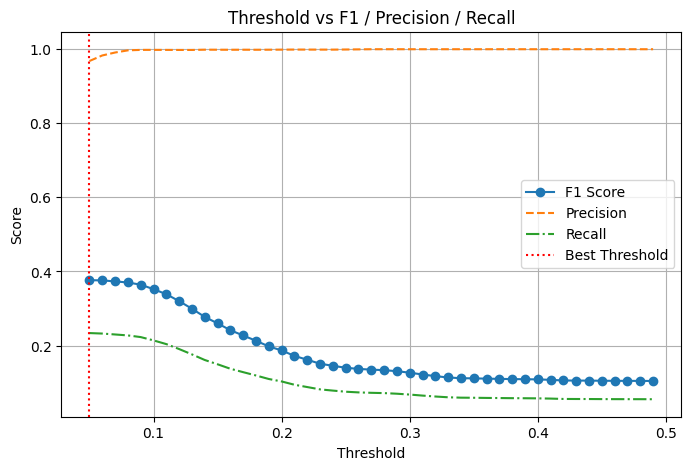

🔥 Best Threshold: 0.05
✅ Best F1 Score: 0.3765
🎯 Precision: 0.9682, Recall: 0.2337


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# Make sure val_preds and val_targets are defined
# If not, use this from your validation loop:
# val_preds, val_targets = [...], [...]

thresholds = np.arange(0.05, 0.5, 0.01)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    pred_bin = [1 if p > t else 0 for p in val_preds]
    f1 = f1_score(val_targets, pred_bin)
    prec = precision_score(val_targets, pred_bin)
    rec = recall_score(val_targets, pred_bin)
    f1_scores.append(f1)
    precisions.append(prec)
    recalls.append(rec)

# Plot F1 Score vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.plot(thresholds, precisions, label='Precision', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', linestyle='-.')
plt.axvline(thresholds[np.argmax(f1_scores)], color='red', linestyle=':', label='Best Threshold')
plt.title("Threshold vs F1 / Precision / Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

# Print best performing threshold
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"🔥 Best Threshold: {best_thresh:.2f}")
print(f"✅ Best F1 Score: {f1_scores[best_idx]:.4f}")
print(f"🎯 Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}")



📋 Final Classification Report:
              precision    recall  f1-score   support

         0.0     0.4565    0.9882    0.6245     22400
         1.0     0.9682    0.2337    0.3765     34392

    accuracy                         0.5313     56792
   macro avg     0.7123    0.6109    0.5005     56792
weighted avg     0.7664    0.5313    0.4743     56792



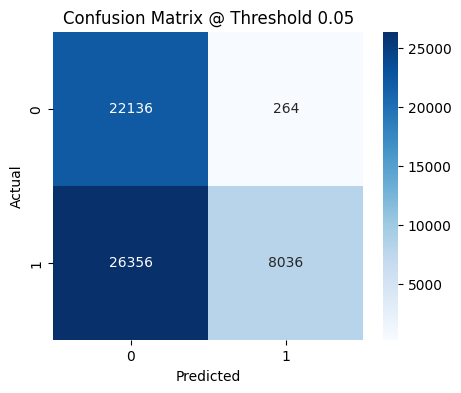

In [45]:
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Step 8: Final Evaluation using best threshold
best_threshold = 0.05  # from your sweep

# Apply threshold to validation predictions
final_preds_binary = [1 if p > best_threshold else 0 for p in val_preds]

# Classification report
print("\n📋 Final Classification Report:")
print(classification_report(val_targets, final_preds_binary, digits=4))

# Confusion matrix
cm = confusion_matrix(val_targets, final_preds_binary)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix @ Threshold {best_threshold}")
plt.show()


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, accuracy_score

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare datasets ON CPU (don't move entire thing to GPU)
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=512)

# Model
input_dim = X_train_seq.shape[2]
model = BiLSTMModel(input_dim=input_dim).to(device)

# Loss with pos_weight
neg = (y_train_seq == 0).sum()
pos = (y_train_seq == 1).sum()
pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# Training Loop
epochs = 2
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy()
            val_preds += probs.tolist()
            val_targets += yb.numpy().tolist()

    val_preds_binary = [1 if p > 0.3 else 0 for p in val_preds]
    val_loss = nn.BCELoss()(torch.tensor(val_preds), torch.tensor(val_targets)).item()
    val_acc = accuracy_score(val_targets, val_preds_binary)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Final Evaluation
print("\n📋 Final Classification Report:")
print(classification_report(val_targets, val_preds_binary, digits=4))



📋 Final Classification Report:
              precision    recall  f1-score   support

         0.0     0.4600    0.9870    0.6276     22400
         1.0     0.9666    0.2455    0.3916     34392

    accuracy                         0.5380     56792
   macro avg     0.7133    0.6162    0.5096     56792
weighted avg     0.7668    0.5380    0.4847     56792



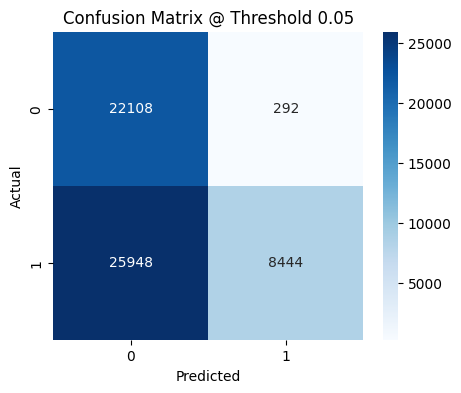

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Step 8: Final Evaluation using best threshold
best_threshold = 0.05  # from your sweep

# Apply threshold to validation predictions
final_preds_binary = [1 if p > best_threshold else 0 for p in val_preds]

# Classification report
print("\n📋 Final Classification Report:")
print(classification_report(val_targets, final_preds_binary, digits=4))

# Confusion matrix
cm = confusion_matrix(val_targets, final_preds_binary)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix @ Threshold {best_threshold}")
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error
import numpy as np

# ✅ Compute MSE & RMSE after training
val_preds = []
val_targets = []

model.eval()
with torch.no_grad():
    for i in range(0, len(X_test_seq), 512):
        xb = torch.tensor(X_test_seq[i:i+512], dtype=torch.float32).to(device)
        yb = torch.tensor(y_test_seq[i:i+512], dtype=torch.float32).to(device)

        logits = model(xb)
        probs = torch.sigmoid(logits)
        val_preds += probs.cpu().numpy().tolist()
        val_targets += yb.cpu().numpy().tolist()

# ✅ Compute metrics
mse = mean_squared_error(val_targets, val_preds)
rmse = np.sqrt(mse)

print(f"\n MSE: {mse:.4f}")
print(f" RMSE: {rmse:.4f}")



📉 MSE: 0.5393
📈 RMSE: 0.7344


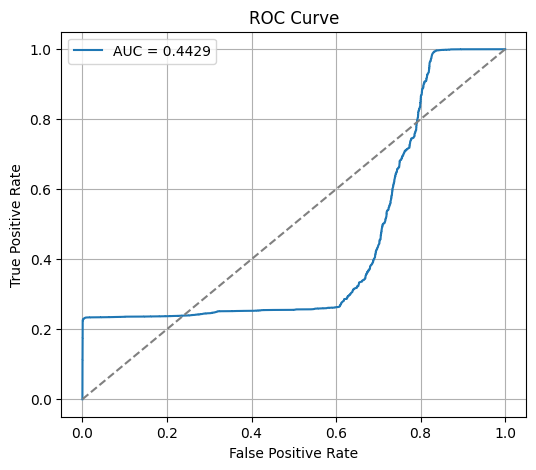

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ROC + AUC
fpr, tpr, _ = roc_curve(val_targets, val_preds)
auc_score = roc_auc_score(val_targets, val_preds)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()